# Part 0: Load in Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get and Analyze IDR clusters

## 1.1 - Load in IDR information

In [2]:
humandf=pd.read_excel('data/Test_all_idrs_clust_30_all_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              14   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1               9   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2              11   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              14   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4               5   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Load in IDR z-score data

In [3]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

90
(24508, 90)


## 1.3 - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length and min inter cluster distance gte 1.5

In [4]:
minidrlength=50
minidrlinkerlength=70
mininterclustdist=1.5

subidrsdf=humandf[humandf['IDR Length']>=minidrlength]
subidrsdf=subidrsdf[ (subidrsdf['IDR Length']>=minidrlinkerlength) | (subidrsdf['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
subidrsdf=subidrsdf[subidrsdf['Min Inter Clust Dist']>=mininterclustdist]
print(subidrsdf.isnull().any())
subidrsdf = subidrsdf.fillna('')
print(subidrsdf)

subaccs=subidrsdf['Uniprot'].tolist()
subaccswnums=subidrsdf['Uniprot w IDRnum'].tolist()
subgeneswnums=subidrsdf['Gene'].tolist()
subclusters=subidrsdf['Cluster Number'].tolist()
subseqlens=subidrsdf['IDR Length'].tolist()
substpos=subidrsdf['Start Pos'].tolist()
subenpos=subidrsdf['End Pos'].tolist()
subproteinlength=subidrsdf['Full Protein Length'].tolist()
submininterclustdist=subidrsdf['Min Inter Clust Dist'].tolist()
subtermini=subidrsdf['IDR Position'].tolist()
subseqs=subidrsdf['Sequence'].tolist()
sublocstring=subidrsdf['HPA Location'].tolist()


sublocationbyunistring=sublocstring


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              14   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              16   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1               1   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1              27   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              29   
...           ...     ...              ...             ...             ...   
24498       24498  Q6ZSZ5         Q6ZSZ5_4   ARHGEF1

## 1.3b - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length - used when don't care about cluster distance

In [5]:
subidrsdfNODIST=humandf[humandf['IDR Length']>=minidrlength]
subidrsdfNODIST=subidrsdfNODIST[ (subidrsdfNODIST['IDR Length']>=minidrlinkerlength) | (subidrsdfNODIST['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
print(subidrsdfNODIST.isnull().any())
subidrsdfNODIST = subidrsdfNODIST.fillna('')
print(subidrsdfNODIST)

subaccsNODIST=subidrsdfNODIST['Uniprot'].tolist()
subaccswnumsNODIST=subidrsdfNODIST['Uniprot w IDRnum'].tolist()
subgeneswnumsNODIST=subidrsdfNODIST['Gene'].tolist()
subclustersNODIST=subidrsdfNODIST['Cluster Number'].tolist()
subseqlensNODIST=subidrsdfNODIST['IDR Length'].tolist()
substposNODIST=subidrsdfNODIST['Start Pos'].tolist()
subenposNODIST=subidrsdfNODIST['End Pos'].tolist()
subproteinlengthNODIST=subidrsdfNODIST['Full Protein Length'].tolist()
submininterclustdistNODIST=subidrsdfNODIST['Min Inter Clust Dist'].tolist()
subterminiNODIST=subidrsdfNODIST['IDR Position'].tolist()
subseqsNODIST=subidrsdfNODIST['Sequence'].tolist()
sublocstringNODIST=subidrsdfNODIST['HPA Location'].tolist()


sublocationbyunistringNODIST=sublocstringNODIST

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              14   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              16   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1               1   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1              27   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              29   
...           ...     ...              ...             ...             ...   
24498       24498  Q6ZSZ5         Q6ZSZ5_4   ARHGEF1

# Part 2: Get enrichment of cluster by subcellular location

## 2.1 - Load in subcellular information from HPA

In [6]:
HPAtable=pd.read_table('../general_data/HPA/subcellular_location.tsv')

print(HPAtable)

tmp=HPAtable[HPAtable['Gene name']=='POLR2A']
print(tmp)

                  Gene        Gene name Reliability            Main location  \
0      ENSG00000000003           TSPAN6    Approved   Cell Junctions;Cytosol   
1      ENSG00000000457            SCYL3   Supported  Cytosol;Golgi apparatus   
2      ENSG00000000460         C1orf112    Approved             Mitochondria   
3      ENSG00000000938              FGR    Approved          Plasma membrane   
4      ENSG00000000971              CFH    Approved                 Vesicles   
...                ...              ...         ...                      ...   
13142  ENSG00000290292            HOMEZ   Supported                 Nucleoli   
13143  ENSG00000290315  ENSG00000290315    Approved      Cytosol;Nucleoplasm   
13144  ENSG00000290317  ENSG00000290317    Approved              Nucleoplasm   
13145  ENSG00000291237             SOD2   Supported             Mitochondria   
13146  ENSG00000291316  ENSG00000291316    Approved              Nucleoplasm   

             Additional location    Ext

## 2.2 - Get all unique locations

In [7]:
allloc=HPAtable['Main location'].tolist()
allens=HPAtable['Gene'].tolist()

uniqueloc=[]
for a in allloc:
    if isinstance(a,str):
        #print(a)
        tmp=a.split(';')
        #print(tmp)
        for i in tmp:
            if i not in uniqueloc:
                uniqueloc.append(i)

uniqueloc.sort(key=str.lower)            
print(uniqueloc)
print(len(uniqueloc))

['Actin filaments', 'Aggresome', 'Cell Junctions', 'Centriolar satellite', 'Centrosome', 'Cytokinetic bridge', 'Cytoplasmic bodies', 'Cytosol', 'Endoplasmic reticulum', 'Endosomes', 'Focal adhesion sites', 'Golgi apparatus', 'Intermediate filaments', 'Kinetochore', 'Lipid droplets', 'Lysosomes', 'Microtubule ends', 'Microtubules', 'Midbody', 'Midbody ring', 'Mitochondria', 'Mitotic chromosome', 'Mitotic spindle', 'Nuclear bodies', 'Nuclear membrane', 'Nuclear speckles', 'Nucleoli', 'Nucleoli fibrillar center', 'Nucleoli rim', 'Nucleoplasm', 'Peroxisomes', 'Plasma membrane', 'Rods & Rings', 'Vesicles']
34


## 2.3 - Get accession for each location

In [8]:
# Load in mapping of accessions to ensemble
ens2uni=pd.read_table('../general_data/HPA/ENSEMBL_to_Uniprot_location_proteins_202312_no_duplicates.tsv')

unimap=ens2uni['Uniprot'].tolist()
ensmap=ens2uni['ENSEMBL'].tolist()
# mapping is bad for POLR2A so add it 
unimap.append('P24928')
ensmap.append('ENSG00000181222')

# make sure have all maps and then remove duplicates
#ens2uniold=pd.read_excel('/project/fava/work/kiersten.ruff/IDRome/2023/HPA/ENSEMBL_to_Uniprot_location_proteins.xlsx')
#mytest=pd.concat([ens2uni,ens2uniold]).drop_duplicates(keep=False)
#print(mytest)
#mytest.to_csv('/project/fava/work/kiersten.ruff/IDRome/2023/HPA/ENSEMBL_to_Uniprot_differences.txt', sep='\t', index=False)
#hi

uniquelocacc=[[] for x in range(len(uniqueloc))]
mappedaccs=[]
count=0
for f in range(0,len(subaccs)):
    if subaccs[f] in unimap:
        idx=unimap.index(subaccs[f])
        if ensmap[idx] in allens:
            # Gets all accessions that can be mapped to HPA
            count=count+1
            mappedaccs.append(subaccs[f])
            
            # find index of ensembl accession in hpa data
            idx2=allens.index(ensmap[idx])
            
            for a in range(0,len(uniqueloc)):
                if uniqueloc[a] in allloc[idx2]:
                    if subaccs[f] not in uniquelocacc[a]:
                        uniquelocacc[a].append(subaccs[f])
                        #print(mygenes[f])
                        #print(subaccs[f])
                        #print(allloc[idx2])
                        #print(idx)
                        #hi

print(len(subaccs))
print('Number of mapped accessions '+str(count))
#print(uniquelocacc)

8548
Number of mapped accessions 6601


## 2.4 - Get subcellular location enrichment by cluster

In [10]:
numkclusts=max(subclusters)+1

pvalsbylocation=np.zeros((len(uniqueloc),numkclusts))
pvalsbylocationlog=np.zeros((len(uniqueloc),numkclusts))

for a in range(0,len(uniqueloc)):
    print(uniqueloc[a])
    sumallidrs=0
    for c in range(0,numkclusts):
        print('Cluster_'+str(c))
        midx = [i for i, x in enumerate(subclusters) if x == c]
        
        topaccs=[]
        for i in midx:
            topaccs.append(subaccswnums[i])
        
        print('Number of IDRs: '+str(len(topaccs)))
    
        # For each location determine if that feature is enriched there
        subfeatureyes=0
        subfeatureno=0
        restfeatureyes=0
        restfeatureno=0
        for s in range(0,len(subaccs)):
            if subaccs[s] in mappedaccs:
                if subaccs[s] in uniquelocacc[a]:
                    if subaccswnums[s] in topaccs:
                        subfeatureyes=subfeatureyes+1
                        sumallidrs=sumallidrs+1
                    else:
                        subfeatureno=subfeatureno+1
                else:
                    if subaccswnums[s] in topaccs:
                        restfeatureyes=restfeatureyes+1
                    else:
                        restfeatureno=restfeatureno+1

        print(subfeatureyes+subfeatureno+restfeatureyes+restfeatureno)

        # defining the table
        if subfeatureyes+restfeatureyes>0:
            data = [[subfeatureyes, subfeatureno], [restfeatureyes, restfeatureno]]
            print(data)
            # One-sided greater used to test if greater occurrence in nucleolus
            res = fisher_exact(data, alternative='greater')
            print(res[1])
            pvalsbylocation[a,c]=res[1]
            pvalsbylocationlog[a,c]=-math.log10(res[1])
            
    print('Number of IDRs in '+uniqueloc[a]+' '+str(subfeatureyes+subfeatureno))
    print(sumallidrs)

print(pvalsbylocation)

Actin filaments
Cluster_0
Number of IDRs: 300
6601
[[6, 84], [227, 6284]]
0.09765122049558708
Cluster_1
Number of IDRs: 284
6601
[[1, 89], [233, 6278]]
0.9620259962362485
Cluster_2
Number of IDRs: 380
6601
[[4, 86], [269, 6242]]
0.5146278611918155
Cluster_3
Number of IDRs: 185
6601
[[1, 89], [92, 6419]]
0.7235586594234853
Cluster_4
Number of IDRs: 156
6601
[[0, 90], [130, 6381]]
1.0
Cluster_5
Number of IDRs: 403
6601
[[5, 85], [328, 6183]]
0.4788010163087144
Cluster_6
Number of IDRs: 157
6601
[[1, 89], [129, 6382]]
0.8351049456162541
Cluster_7
Number of IDRs: 248
6601
[[2, 88], [187, 6324]]
0.7346929188430549
Cluster_8
Number of IDRs: 274
6601
[[3, 87], [223, 6288]]
0.6004880087122988
Cluster_9
Number of IDRs: 323
6601
[[10, 80], [247, 6264]]
0.0024671011871422958
Cluster_10
Number of IDRs: 121
6601
[[0, 90], [78, 6433]]
1.0
Cluster_11
Number of IDRs: 362
6601
[[3, 87], [295, 6216]]
0.7797039467797935
Cluster_12
Number of IDRs: 351
6601
[[2, 88], [270, 6241]]
0.8913350866387002
Cluster

6601
[[0, 60], [123, 6418]]
1.0
Cluster_23
Number of IDRs: 390
6601
[[2, 58], [318, 6223]]
0.7956128425077157
Cluster_24
Number of IDRs: 193
6601
[[1, 59], [141, 6400]]
0.730376796570702
Cluster_25
Number of IDRs: 515
6601
[[5, 55], [418, 6123]]
0.33959281060799723
Cluster_26
Number of IDRs: 531
6601
[[5, 55], [403, 6138]]
0.31220896583100405
Cluster_27
Number of IDRs: 186
6601
[[1, 59], [131, 6410]]
0.7040254489978557
Cluster_28
Number of IDRs: 292
6601
[[1, 59], [220, 6321]]
0.8715902264160342
Cluster_29
Number of IDRs: 295
6601
[[3, 57], [245, 6296]]
0.3933310790446616
Number of IDRs in Centriolar satellite 60
60
Centrosome
Cluster_0
Number of IDRs: 300
6601
[[3, 90], [230, 6278]]
0.6435649232864733
Cluster_1
Number of IDRs: 284
6601
[[5, 88], [229, 6279]]
0.2334952788420097
Cluster_2
Number of IDRs: 380
6601
[[3, 90], [270, 6238]]
0.7466806986189536
Cluster_3
Number of IDRs: 185
6601
[[0, 93], [93, 6415]]
1.0
Cluster_4
Number of IDRs: 156
6601
[[0, 93], [130, 6378]]
1.0
Cluster_5
N

6601
[[57, 1258], [215, 5071]]
0.3552751051067612
Cluster_13
Number of IDRs: 260
6601
[[37, 1278], [166, 5120]]
0.7563519867623221
Cluster_14
Number of IDRs: 279
6601
[[45, 1270], [149, 5137]]
0.14318762866993745
Cluster_15
Number of IDRs: 214
6601
[[19, 1296], [131, 5155]]
0.9931729366029637
Cluster_16
Number of IDRs: 298
6601
[[42, 1273], [220, 5066]]
0.9571422828721817
Cluster_17
Number of IDRs: 422
6601
[[65, 1250], [281, 5005]]
0.727179253771097
Cluster_18
Number of IDRs: 121
6601
[[22, 1293], [73, 5213]]
0.2482176680543916
Cluster_19
Number of IDRs: 500
6601
[[79, 1236], [230, 5056]]
0.007922171670455402
Cluster_20
Number of IDRs: 153
6601
[[23, 1292], [101, 5185]]
0.6854370072050509
Cluster_21
Number of IDRs: 198
6601
[[14, 1301], [141, 5145]]
0.9999418273381944
Cluster_22
Number of IDRs: 157
6601
[[17, 1298], [106, 5180]]
0.9703748919361793
Cluster_23
Number of IDRs: 390
6601
[[77, 1238], [243, 5043]]
0.03575043167872665
Cluster_24
Number of IDRs: 193
6601
[[29, 1286], [113, 51

6601
[[8, 311], [226, 6056]]
0.8860599603040067
Cluster_2
Number of IDRs: 380
6601
[[9, 310], [264, 6018]]
0.9185848912886178
Cluster_3
Number of IDRs: 185
6601
[[5, 314], [88, 6194]]
0.4697510785463243
Cluster_4
Number of IDRs: 156
6601
[[4, 315], [126, 6156]]
0.8809316151357718
Cluster_5
Number of IDRs: 403
6601
[[18, 301], [315, 5967]]
0.3447437086091452
Cluster_6
Number of IDRs: 157
6601
[[7, 312], [123, 6159]]
0.4404330556857445
Cluster_7
Number of IDRs: 248
6601
[[6, 313], [183, 6099]]
0.9012883144676493
Cluster_8
Number of IDRs: 274
6601
[[9, 310], [217, 6065]]
0.7721356829811604
Cluster_9
Number of IDRs: 323
6601
[[8, 311], [249, 6033]]
0.9358421626596555
Cluster_10
Number of IDRs: 121
6601
[[10, 309], [68, 6214]]
0.004068638462353639
Cluster_11
Number of IDRs: 362
6601
[[15, 304], [283, 5999]]
0.47391370969415714
Cluster_12
Number of IDRs: 351
6601
[[19, 300], [253, 6029]]
0.06656235868944664
Cluster_13
Number of IDRs: 260
6601
[[11, 308], [192, 6090]]
0.3921166822294801
Clust

6601
[[0, 6], [132, 6463]]
1.0
Cluster_28
Number of IDRs: 292
6601
[[0, 6], [221, 6374]]
1.0
Cluster_29
Number of IDRs: 295
6601
[[0, 6], [248, 6347]]
1.0
Number of IDRs in Lipid droplets 6
6
Lysosomes
Cluster_0
Number of IDRs: 300
6601
[[2, 4], [231, 6364]]
0.016941047973897644
Cluster_1
Number of IDRs: 284
6601
[[0, 6], [234, 6361]]
1.0
Cluster_2
Number of IDRs: 380
6601
[[0, 6], [273, 6322]]
1.0
Cluster_3
Number of IDRs: 185
6601
[[0, 6], [93, 6502]]
1.0
Cluster_4
Number of IDRs: 156
6601
[[1, 5], [129, 6466]]
0.11253718468947235
Cluster_5
Number of IDRs: 403
6601
[[0, 6], [333, 6262]]
1.0
Cluster_6
Number of IDRs: 157
6601
[[0, 6], [130, 6465]]
1.0
Cluster_7
Number of IDRs: 248
6601
[[0, 6], [189, 6406]]
1.0
Cluster_8
Number of IDRs: 274
6601
[[0, 6], [226, 6369]]
1.0
Cluster_9
Number of IDRs: 323
6601
[[0, 6], [257, 6338]]
1.0
Cluster_10
Number of IDRs: 121
6601
[[0, 6], [78, 6517]]
1.0
Cluster_11
Number of IDRs: 362
6601
[[0, 6], [298, 6297]]
1.0
Cluster_12
Number of IDRs: 351
66

6601
[[2, 11], [406, 6182]]
0.18993243777815266
Cluster_27
Number of IDRs: 186
6601
[[0, 13], [132, 6456]]
1.0
Cluster_28
Number of IDRs: 292
6601
[[1, 12], [220, 6368]]
0.35795671783074934
Cluster_29
Number of IDRs: 295
6601
[[0, 13], [248, 6340]]
1.0
Number of IDRs in Midbody 13
13
Midbody ring
Cluster_0
Number of IDRs: 300
6601
[[0, 4], [233, 6364]]
1.0
Cluster_1
Number of IDRs: 284
6601
[[0, 4], [234, 6363]]
1.0
Cluster_2
Number of IDRs: 380
6601
[[1, 3], [272, 6325]]
0.15548004767832505
Cluster_3
Number of IDRs: 185
6601
[[0, 4], [93, 6504]]
1.0
Cluster_4
Number of IDRs: 156
6601
[[0, 4], [130, 6467]]
1.0
Cluster_5
Number of IDRs: 403
6601
[[1, 3], [332, 6265]]
0.1870645910149603
Cluster_6
Number of IDRs: 157
6601
[[0, 4], [130, 6467]]
1.0
Cluster_7
Number of IDRs: 248
6601
[[0, 4], [189, 6408]]
1.0
Cluster_8
Number of IDRs: 274
6601
[[0, 4], [226, 6371]]
1.0
Cluster_9
Number of IDRs: 323
6601
[[0, 4], [257, 6340]]
1.0
Cluster_10
Number of IDRs: 121
6601
[[0, 4], [78, 6519]]
1.0
C

6601
[[0, 15], [155, 6431]]
1.0
Cluster_22
Number of IDRs: 157
6601
[[0, 15], [123, 6463]]
1.0
Cluster_23
Number of IDRs: 390
6601
[[0, 15], [320, 6266]]
1.0
Cluster_24
Number of IDRs: 193
6601
[[0, 15], [142, 6444]]
1.0
Cluster_25
Number of IDRs: 515
6601
[[0, 15], [423, 6163]]
1.0
Cluster_26
Number of IDRs: 531
6601
[[2, 13], [406, 6180]]
0.23639984363429026
Cluster_27
Number of IDRs: 186
6601
[[1, 14], [131, 6455]]
0.2616366944659212
Cluster_28
Number of IDRs: 292
6601
[[0, 15], [221, 6365]]
1.0
Cluster_29
Number of IDRs: 295
6601
[[0, 15], [248, 6338]]
1.0
Number of IDRs in Mitotic spindle 15
15
Nuclear bodies
Cluster_0
Number of IDRs: 300
6601
[[10, 223], [223, 6145]]
0.30786128788922057
Cluster_1
Number of IDRs: 284
6601
[[8, 225], [226, 6142]]
0.5887508976679807
Cluster_2
Number of IDRs: 380
6601
[[8, 225], [265, 6103]]
0.7554984729324141
Cluster_3
Number of IDRs: 185
6601
[[2, 231], [91, 6277]]
0.8462543874711129
Cluster_4
Number of IDRs: 156
6601
[[6, 227], [124, 6244]]
0.3101

6601
[[17, 500], [316, 5768]]
0.9823128361584441
Cluster_6
Number of IDRs: 157
6601
[[10, 507], [120, 5964]]
0.5719536152548755
Cluster_7
Number of IDRs: 248
6601
[[10, 507], [179, 5905]]
0.9343078616691773
Cluster_8
Number of IDRs: 274
6601
[[17, 500], [209, 5875]]
0.6071334497772463
Cluster_9
Number of IDRs: 323
6601
[[32, 485], [225, 5859]]
0.0055442925205003565
Cluster_10
Number of IDRs: 121
6601
[[1, 516], [77, 6007]]
0.9983393758559919
Cluster_11
Number of IDRs: 362
6601
[[12, 505], [286, 5798]]
0.9976907896099197
Cluster_12
Number of IDRs: 351
6601
[[15, 502], [257, 5827]]
0.9474979122018984
Cluster_13
Number of IDRs: 260
6601
[[8, 509], [195, 5889]]
0.9922206993614909
Cluster_14
Number of IDRs: 279
6601
[[11, 506], [183, 5901]]
0.9035075742270584
Cluster_15
Number of IDRs: 214
6601
[[12, 505], [138, 5946]]
0.5138252815076573
Cluster_16
Number of IDRs: 298
6601
[[57, 460], [205, 5879]]
3.8282284676916774e-13
Cluster_17
Number of IDRs: 422
6601
[[25, 492], [321, 5763]]
0.69686882

6601
[[29, 3118], [66, 3388]]
0.9997901616332443
Cluster_19
Number of IDRs: 500
6601
[[123, 3024], [186, 3268]]
0.9981718471556397
Cluster_20
Number of IDRs: 153
6601
[[61, 3086], [63, 3391]]
0.4004267489161873
Cluster_21
Number of IDRs: 198
6601
[[89, 3058], [66, 3388]]
0.008731938415547525
Cluster_22
Number of IDRs: 157
6601
[[78, 3069], [45, 3409]]
0.0002836204637682243
Cluster_23
Number of IDRs: 390
6601
[[139, 3008], [181, 3273]]
0.9468453735195661
Cluster_24
Number of IDRs: 193
6601
[[56, 3091], [86, 3368]]
0.9812370993356339
Cluster_25
Number of IDRs: 515
6601
[[212, 2935], [211, 3243]]
0.16113190880254286
Cluster_26
Number of IDRs: 531
6601
[[212, 2935], [196, 3258]]
0.04113537067649677
Cluster_27
Number of IDRs: 186
6601
[[70, 3077], [62, 3392]]
0.12378707146458512
Cluster_28
Number of IDRs: 292
6601
[[107, 3040], [114, 3340]]
0.43763439630879486
Cluster_29
Number of IDRs: 295
6601
[[100, 3047], [148, 3306]]
0.9925761657228872
Number of IDRs in Nucleoplasm 3147
3147
Peroxisome

6601
[[23, 554], [275, 5749]]
0.7682377702082555
Cluster_12
Number of IDRs: 351
6601
[[36, 541], [236, 5788]]
0.007265091368505687
Cluster_13
Number of IDRs: 260
6601
[[15, 562], [188, 5836]]
0.7905831659982001
Cluster_14
Number of IDRs: 279
6601
[[19, 558], [175, 5849]]
0.3351089089130966
Cluster_15
Number of IDRs: 214
6601
[[12, 565], [138, 5886]]
0.6701850853401745
Cluster_16
Number of IDRs: 298
6601
[[7, 570], [255, 5769]]
0.9999874395753509
Cluster_17
Number of IDRs: 422
6601
[[45, 532], [301, 5723]]
0.003987196043744982
Cluster_18
Number of IDRs: 121
6601
[[10, 567], [85, 5939]]
0.316718783666029
Cluster_19
Number of IDRs: 500
6601
[[31, 546], [278, 5746]]
0.231930764245593
Cluster_20
Number of IDRs: 153
6601
[[8, 569], [116, 5908]]
0.8603668430572939
Cluster_21
Number of IDRs: 198
6601
[[10, 567], [145, 5879]]
0.8816586471693096
Cluster_22
Number of IDRs: 157
6601
[[9, 568], [114, 5910]]
0.7595774628500083
Cluster_23
Number of IDRs: 390
6601
[[25, 552], [295, 5729]]
0.7553903748

## 2.5 - Save p-values

In [11]:
#np.savetxt('data/Test_all_idrs_clust_30_subcellular_location_HPA_enrichment_by_cluster_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt', pvalsbylocationlog)

## 2.6 - Plot p-values by sorted clusters

[[ 1.01032232e+00  1.68131921e-02  2.88506705e-01 ... -0.00000000e+00
  -0.00000000e+00  9.14468530e-01]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 9.55664673e-01  2.94407714e-03  3.26189387e-02 ...  2.84261453e-01
   3.12239972e-01  1.42148951e-02]
 ...
 [ 1.32511355e+00  4.05453351e-04  2.80811795e-01 ...  1.04689790e-01
   8.17528099e-03  1.32525266e+00]
 [-0.00000000e+00  1.45039388e+00 -0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 1.49593437e+00  6.34690356e-01  5.59435486e-01 ...  4.51416300e-02
   1.00870331e-02  1.95451071e-02]]
[ True  True False  True  True  True False  True  True  True  True False
  True False False  True  True  True  True  True  True  True  True False
  True  True False False  True False]
[2.50855657e-01 2.90523961e+00 3.77681241e-02 1.88744472e-03
 4.91254880e-02 7.75018087e-03 2.42639191e-01 2.95099968e-02
 2.16715839e-01 2.25615386e+00 7.21799387e-04 1.00403704e-

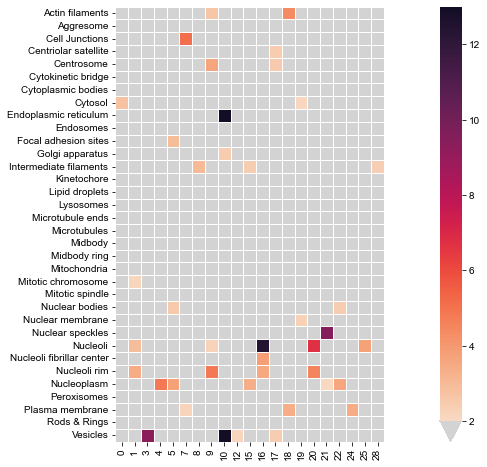

In [10]:
import matplotlib as mpl
import seaborn as sbn
import math

numkclusts=max(subclusters)+1

#myclustorder=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#myclustorder=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
myclustorder=np.arange(0,numkclusts,1)

#tmp=np.loadtxt("other_subsets/subcellular_location_HPA_enrichment_by_cluster_all_human_gte_70_and_nonlinkers_gte_50.txt")
tmp=np.loadtxt('data/Test_all_idrs_clust_30_subcellular_location_HPA_enrichment_by_cluster_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt')


pvalsbylocationlog2=tmp
pvalsbylocationlog2[:] = pvalsbylocationlog2[:, myclustorder]
print(pvalsbylocationlog2)

mymask=np.any(pvalsbylocationlog2 > -math.log10(0.01), axis=0);
print(np.any(pvalsbylocationlog2 > -math.log10(0.01), axis=0))
#print(pvalsbylocation[:,mymask])

mysubfeats=[]
for i in range(0,len(mymask)):
    if mymask[i] == True:
        mysubfeats.append(myclustorder[i])


c = sbn.color_palette('rocket_r', 20)
green = mpl.colors.LinearSegmentedColormap.from_list('alex_lv', c)
green.set_under(alpha=0)
green.set_under('lightgrey')

## If want to look at all 90 features
fig, ax = plt.subplots(figsize = (20, 8)) 
sbn.heatmap(pvalsbylocationlog2[:,mymask],cmap=green,vmin=-math.log10(0.01), vmax=13, cbar_kws={'extend': 'min'}, square=True, linewidth=.5)
plt.yticks(np.arange(0.5, len(uniqueloc), 1), uniqueloc,rotation=0) 
plt.xticks(np.arange(0.5, len(mysubfeats), 1), mysubfeats,rotation=90) 

plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Test_all_idrs_clust_30_fisher_exact_test_pvals_location_heatmap_by_cluster_median_sorted_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.pdf', transparent=True, bbox_inches = "tight") 


tmpidx=uniqueloc.index('Nucleoli')
print(pvalsbylocationlog2[tmpidx,:])

tmpidx=uniqueloc.index('Nuclear speckles')
print(pvalsbylocationlog2[tmpidx,:])

tmpidx=uniqueloc.index('Nucleoplasm')
print(pvalsbylocationlog2[tmpidx,:])

## 2.7 - Plot p-values by sorted clusters and sorted rows by number of IDRs

In [11]:
numIDRsbyloc=[]
for a in range(0,len(uniqueloc)):
    print(uniqueloc[a])
    print(len(uniquelocacc[a]))
    sumallidrs=0
    for s in range(0,len(subaccs)):
        if subaccs[s] in mappedaccs:
            if subaccs[s] in uniquelocacc[a]:
                sumallidrs=sumallidrs+1
    numIDRsbyloc.append(sumallidrs)
    print(sumallidrs)
    
print(numIDRsbyloc)

Actin filaments
59
90
Aggresome
0
0
Cell Junctions
79
137
Centriolar satellite
42
60
Centrosome
61
93
Cytokinetic bridge
8
21
Cytoplasmic bodies
15
20
Cytosol
889
1315
Endoplasmic reticulum
110
145
Endosomes
5
7
Focal adhesion sites
34
53
Golgi apparatus
222
319
Intermediate filaments
31
47
Kinetochore
2
4
Lipid droplets
4
6
Lysosomes
4
6
Microtubule ends
4
6
Microtubules
55
84
Midbody
6
13
Midbody ring
2
4
Mitochondria
126
166
Mitotic chromosome
17
22
Mitotic spindle
8
15
Nuclear bodies
134
233
Nuclear membrane
66
124
Nuclear speckles
181
307
Nucleoli
350
517
Nucleoli fibrillar center
78
114
Nucleoli rim
73
107
Nucleoplasm
1995
3147
Peroxisomes
6
6
Plasma membrane
486
772
Rods & Rings
1
1
Vesicles
395
577
[90, 0, 137, 60, 93, 21, 20, 1315, 145, 7, 53, 319, 47, 4, 6, 6, 6, 84, 13, 4, 166, 22, 15, 233, 124, 307, 517, 114, 107, 3147, 6, 772, 1, 577]


## 2.8 - Plot p-values by sorted clusters and sorted rows by IDR enrichment

                     Location  Number of IDRs          IDRs         1  \
29                Nucleoplasm            3147  6.046537e+01  0.669263   
25           Nuclear speckles             307  8.098650e+00  0.891752   
26                   Nucleoli             517  6.543247e+00  2.905240   
28               Nucleoli rim             107  6.535094e+00  3.429181   
23             Nuclear bodies             233  3.402037e+00  0.230068   
0             Actin filaments              90  2.226644e+00  0.016813   
2              Cell Junctions             137  2.171919e+00  0.002944   
3        Centriolar satellite              60  1.913969e+00  0.198113   
27  Nucleoli fibrillar center             114  1.552406e+00  0.961010   
10       Focal adhesion sites              53  1.031792e+00  0.068804   
24           Nuclear membrane             124  5.849238e-01  0.346769   
12     Intermediate filaments              47  8.174687e-02  0.087376   
4                  Centrosome              93  3.97

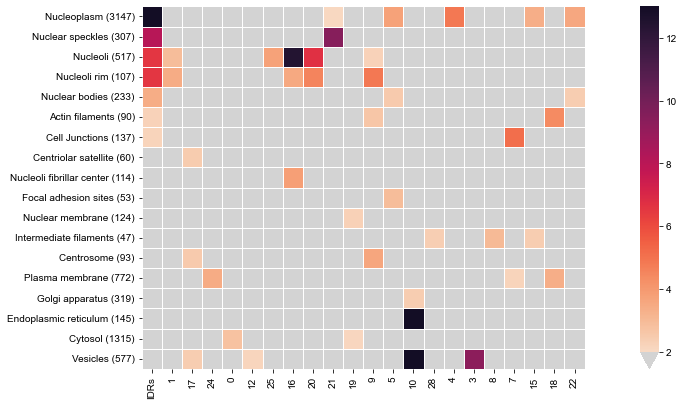

In [15]:
numkclusts=max(subclusters)+1
minIDRnum=25

#myclustorder=[7, 3, 13, 2, 8, 19, 4, 24, 18, 12, 5, 9, 23, 14, 25, 26, 29, 17, 10, 1, 21, 27, 22, 0, 20, 16, 11, 15, 6, 28]
myclustorder=[1, 17, 23, 24, 27, 0, 29, 12, 25, 16, 20, 2, 21, 19, 9, 5, 11, 14, 10,28, 26, 4, 3, 8, 7, 6, 13, 15, 18, 22]

for i in range(0,30):
    if i not in myclustorder:
        print(i)
#hi

tmp=np.loadtxt('data/Test_all_idrs_clust_30_subcellular_location_HPA_enrichment_by_cluster_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'.txt')
tmp2=np.loadtxt('../general_data/subcellular_location_HPA_enrichment_in_IDRs_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.txt')

# Create data frame of locations, number of IDRs, enrichment of IDRs, cluster enrichment 
dfenrichloc=pd.DataFrame()
dfenrichloc['Location']=uniqueloc
dfenrichloc['Number of IDRs']=numIDRsbyloc
dfenrichloc['IDRs']=tmp2
#print(dfenrichloc)

for i in range(0,len(myclustorder)):
    dfenrichloc[myclustorder[i]]=tmp[:,myclustorder[i]]
    
# Only keep locations if have at least minIDRnum
dfenrichloc=dfenrichloc[dfenrichloc['Number of IDRs']>=minIDRnum]

# Sort by enrichment in proteins having IDRs
dfenrichloc=dfenrichloc.sort_values(by=['IDRs','Number of IDRs'],ascending=False)
print(dfenrichloc)

# Convert data to numpy array
allcolumns=dfenrichloc.columns.values.tolist()
datacolumns=allcolumns[2:]
tmppvalsbylocationlog=dfenrichloc[datacolumns].to_numpy()
print(np.shape(tmppvalsbylocationlog))

# Get names for plotting
sortedlocnamesnonums=dfenrichloc['Location'].tolist()
sortedidrnums=dfenrichloc['Number of IDRs'].tolist()
sortedlocnames=[]
for i in range(0,len(sortedlocnamesnonums)):
    sortedlocnames.append(sortedlocnamesnonums[i]+' ('+str(sortedidrnums[i])+')')


pvalsbylocationlog2=tmppvalsbylocationlog
print(pvalsbylocationlog2)

mymask=np.any(pvalsbylocationlog2 > -math.log10(0.01), axis=0);
mymask2=np.any(pvalsbylocationlog2 > -math.log10(0.01), axis=1);
print(np.any(pvalsbylocationlog2 > -math.log10(0.01), axis=0))
#print(pvalsbylocation[:,mymask])

mysubfeats=[]
for i in range(0,len(mymask)):
    if mymask[i] == True:
        mysubfeats.append(datacolumns[i])

mysublocnames=[]
for i in range(0,len(mymask2)):
    if mymask2[i] == True:
        mysublocnames.append(sortedlocnames[i])
        
c = sbn.color_palette('rocket_r', 20)
green = mpl.colors.LinearSegmentedColormap.from_list('alex_lv', c)
green.set_under(alpha=0)
green.set_under('lightgrey')

## If want to look at all 90 features
fig, ax = plt.subplots(figsize = (20, len(sortedlocnames)/3)) 
tmp=pvalsbylocationlog2[:,mymask]
maskedvals=tmp[mymask2,:]
sbn.heatmap(maskedvals,cmap=green,vmin=-math.log10(0.01), vmax=13, cbar_kws={'extend': 'min'}, square=True, linewidth=.5)
plt.yticks(np.arange(0.5, len(mysublocnames), 1), mysublocnames,rotation=0) 
plt.xticks(np.arange(0.5, len(mysubfeats), 1), mysubfeats,rotation=90)

#plt.savefig('Test_all_idrs_clust_30_fisher_exact_test_pvals_location_heatmap_by_cluster_median_sorted_by_IDR_enrichment_if_enriched_all_human_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_idrs_dist_gte_'+str(mininterclustdist)+'_gte_'+str(minIDRnum)+'_IDRs.pdf', transparent=True, bbox_inches = "tight") 


#with pd.ExcelWriter('../Supplementary_Tables/Table_S1.xlsx', engine='openpyxl',mode='a') as writer:
#    dfenrichloc.to_excel(writer,sheet_name='Fig_S1F')